In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
from operator import add
import random
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score,roc_curve, auc

from ipynb.fs.full.GenerateData import generatedata
from ipynb.fs.full.AnalysisPartFunctions_GDTHETA import initialize_parameters,initialize_dicts,calc_prior_mean,calc_post_mean,calc_post_sd,calc_y,calc_L,calc_component_derivs,calc_gradients,update_parameters, predict_choice

**(a) Generate data**

In [2]:
#data = pd.DataFrame(generatedata())

In [3]:
data = pd.read_csv('data/people.csv')

In [4]:
data.head()

,index,id,name,first,last,sex,race,dob,age,age_cat,...,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,is_violent_recid,num_vr_cases,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc
0,0,1,miguel hernandez,miguel,hernandez,Male,Other,1947-04-18 00:00:00.000000,69,Greater than 45,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
1,1,2,michael ryan,michael,ryan,Male,Caucasian,1985-02-06 00:00:00.000000,31,25 - 45,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
2,2,3,kevon dixon,kevon,dixon,Male,African-American,1982-01-22 00:00:00.000000,34,25 - 45,...,2013-07-05 00:00:00.000000,Felony Battery (Dom Strang),NaN,NaN,1,NaN,13009779CF10A,(F3),2013-07-05 00:00:00.000000,Felony Battery (Dom Strang)
3,3,4,ed philo,ed,philo,Male,African-American,1991-05-14 00:00:00.000000,24,Less than 25,...,2013-06-16 00:00:00.000000,Driving Under The Influence,2013-06-16 09:05:47.000000,2013-06-16 07:18:55.000000,0,NaN,NaN,NaN,NaN,NaN
4,4,5,marcu brown,marcu,brown,Male,African-American,1993-01-21 00:00:00.000000,23,Less than 25,...,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


**(b) Create dummy variables for categorical variables**

In [5]:
sex_dummies = pd.get_dummies(data['sex'])
race_dummies = pd.get_dummies(data['race'])
age_dummies = pd.get_dummies(data['age_cat'])

data['sex_1_male'] = sex_dummies['Male']
data['African_American']=race_dummies['African-American']
data['Asian']=race_dummies['Asian']
data['Caucasian']=race_dummies['Caucasian']
data['Hispanic'] = race_dummies['Hispanic']
data['Native_American']=race_dummies['Native American']
data['race_Other']=race_dummies['Other']
data['Greater_45']=age_dummies['Greater than 45']
data['25_45']=age_dummies['25 - 45']
data['Less_25']=age_dummies['Less than 25']

In [6]:
data.columns

Index(['index', 'id', 'name', 'first', 'last', 'sex', 'race', 'dob', 'age',
       'age_cat', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'compas_screening_date', 'decile_score', 'score_text', 'violent_recid',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_case_number', 'c_days_from_compas', 'c_arrest_date',
       'c_offense_date', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'num_r_cases', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out',
       'is_violent_recid', 'num_vr_cases', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'sex_1_male',
       'African_American', 'Asian', 'Caucasian', 'Hispanic', 'Native_American',
       'race_Other', 'Greater_45', '25_45', 'Less_25'],
      dtype='object')

**(c) Split data into training & test**

In [7]:
# select out relevant data & generate the train and test data

# train / test
features = ['Less_25','25_45','Greater_45','sex_1_male','African_American','Caucasian','is_violent_recid','juv_fel_count']
X = data[features]
mu_ra = data['decile_score'].tolist()

# need to calculate the 'release' value (i.e. 'y')
synth_params = {'B': np.array([[0.57140259],
                     [0.42888905],
                     [0.5780913 ],
                     [0.20609823],
                     [0.81332125],
                     [0.82358887],
                     [0.65347253],
                     [0.16022956]]),
                  'b': 5.206693596399246,
                  'q': 0.32777281162209315,
                  'sd_prior': 2.4999667668640035,
                  'tau': 6,
                  'Theta': 1}

synth_mu_prior = calc_prior_mean(X, synth_params)
synth_mu_post = calc_post_mean(synth_mu_prior, mu_ra, synth_params)
synth_sd_post =calc_post_sd(synth_mu_prior, mu_ra, synth_params)
synth_y_pred = calc_y(synth_mu_post, synth_sd_post, synth_params)
y = [1 if syP>0.5 else 0 for syP in synth_y_pred]
values, counts = np.unique(y, return_counts=True)
print(values,counts)

[0 1] [ 1721 10036]


Create a list of indices to pull out 70% of observations as a train set

In [8]:
train_index = random.sample(range(len(X)),math.floor(len(X)*0.7))
test_index = [i for i in range(len(X)) if i not in train_index ]
print(len(test_index),len(train_index))

3528 8229


In [9]:
X_train = data.loc[train_index,features]
mu_ra_train = data.loc[train_index,'decile_score'].tolist()
y_train = [y[i] for i in train_index]

X_test = data.loc[test_index,features]
mu_ra_test = data.loc[test_index,'decile_score'].tolist()
y_test = [y[i] for i in test_index]

Define variables for analysis without penalties

In [10]:
initial_parameters = initialize_parameters(X_train,1,10)
derivatives,grads = initialize_dicts()

In [11]:
initial_parameters

{'B': array([[0.55410884],
        [0.45420353],
        [0.05593455],
        [0.75623468],
        [0.06818729],
        [0.94388916],
        [0.71823124],
        [0.31731482]]),
 'b': 2.9402937343974123,
 'q': 0.9649159328289648,
 'sd_prior': 7.0457300920497365,
 'tau': 2,
 'Theta': 3}

In [12]:
parameters = {
    "B": initial_parameters['B'],
    "b": initial_parameters['b'],
    "q" : initial_parameters['q'],
    "sd_prior" : initial_parameters['sd_prior'],
    "tau" : initial_parameters['tau'],
    "Theta" : initial_parameters['Theta']
}

In [13]:
num_int = 500

prev_L = 0 
loss = []

init_lr = 0.001
learning_rate = []

j = 0
    
while j < num_int:
    mu_prior = calc_prior_mean(X_train, parameters)
    mu_post = calc_post_mean(mu_prior, mu_ra_train, parameters)
    sd_post =calc_post_sd(mu_prior, mu_ra_train, parameters)
    y_pred = calc_y(mu_post, sd_post, parameters)
    L = calc_L(y_pred, y_train)
    loss.append(L)
        
    # set learning rate: if loss is negative double learning rate; else halve learning rate
    if j==0:
        lr=init_lr
    elif prev_L>L and lr<=0.5:
        lr = lr*2
    elif prev_L>L and lr>0.5:
        lr = 1
    elif prev_L<L:
        lr = lr/2

    learning_rate.append(lr)
        
    derivatives = calc_component_derivs(X_train,parameters, derivatives, mu_prior, mu_ra_train, mu_post, sd_post, y_pred, y_train)
    grads = calc_gradients(X_train,grads,derivatives)
    parameters = update_parameters(parameters, grads, lr)
    prev_L = L
    #print("intermediate params: ",parameters)
        
    # print loss so we can track the progress of the model
    if j%10==0:
        print("loss: ", L)
        #print("theta: "+str(parameters['Theta']))
    j+=1
    

loss:  0.5016822259983118
loss:  0.5016674272733052
loss:  0.5015226535932242
loss:  0.5014105300775348
loss:  0.5012562943127212
loss:  0.5011109241715376
loss:  0.4988648045657344
loss:  0.49889447452062086
loss:  0.49872827304231504
loss:  0.49863519098779296
loss:  0.4987592096827255
loss:  0.4985358618501569
loss:  0.4983769832535805
loss:  0.4982177852793517
loss:  0.4953889965754247
loss:  0.49643395700949966
loss:  0.4962599165978064
loss:  0.49608541371474657
loss:  0.4959104449145161
loss:  0.49573500672093523
loss:  0.4955590956278244
loss:  0.49770395866699046
loss:  0.49760404657698143
loss:  0.49747298341607904
loss:  0.49643444128747866
loss:  0.4962645622327012
loss:  0.4962133998521881
loss:  0.49604297641995143
loss:  0.49664417257908755
loss:  0.4964552580877673
loss:  0.49628556149638775
loss:  0.4961114486729296
loss:  0.49594080028272297
loss:  0.4949387793329925
loss:  0.49476276438743544
loss:  0.4991829083613314
loss:  0.4990198239747984
loss:  0.49891677386566

In [14]:
parameters

{'B': array([[0.56614283],
        [0.48743953],
        [0.06959738],
        [0.80346628],
        [0.11354887],
        [0.97421322],
        [0.72623099],
        [0.32458411]]),
 'b': 2.9992265553723483,
 'q': 0.7279078509317827,
 'sd_prior': 6.85045352199997,
 'tau': 2.137236450261301,
 'Theta': 2.4917887928801923}

In [15]:
initial_parameters

{'B': array([[0.55410884],
        [0.45420353],
        [0.05593455],
        [0.75623468],
        [0.06818729],
        [0.94388916],
        [0.71823124],
        [0.31731482]]),
 'b': 2.9402937343974123,
 'q': 0.9649159328289648,
 'sd_prior': 7.0457300920497365,
 'tau': 2,
 'Theta': 3}

In [16]:
synth_params

{'B': array([[0.57140259],
        [0.42888905],
        [0.5780913 ],
        [0.20609823],
        [0.81332125],
        [0.82358887],
        [0.65347253],
        [0.16022956]]),
 'b': 5.206693596399246,
 'q': 0.32777281162209315,
 'sd_prior': 2.4999667668640035,
 'tau': 6,
 'Theta': 1}

No handles with labels found to put in legend.


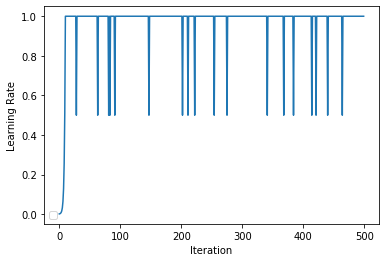

In [17]:
plt.plot(learning_rate)
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.legend(loc="lower left")

No handles with labels found to put in legend.


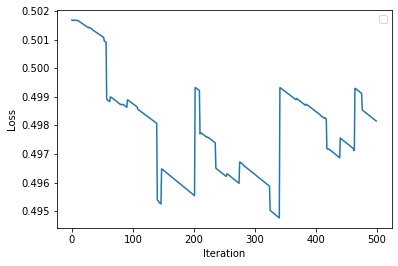

In [18]:
plt.plot(loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(loc="upper right")

In [41]:
from sklearn.metrics import confusion_matrix

y_pred_convert = pd.Series([1 if y>0.5 else 0 for y in y_pred],name="Predicted")
y_actual = pd.Series(y_test,name="Actual")
confusion = pd.crosstab(y_actual, y_pred_convert,margins=True)
confusion

Predicted,0,1,All
Actual,,,
0,42,440,482
1,11,3035,3046
All,53,3475,3528


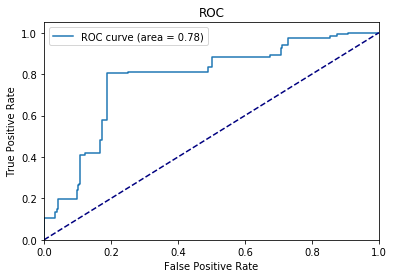

In [19]:
y_pred = predict_choice(X_test,mu_ra_test,parameters)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="upper left")

Define variables for analysis with penalties

In [ ]:
parameters = initialize_parameters(X_test,1,10)
derivatives,grads = initialize_dicts()

X = X_train
y = np.array(y_train)
mu_ra = np.array(risk_assess_train)
theta = 5
num_int = 100
learning_rate = 0.001
k = 1

In [ ]:
parameters

In [ ]:
loss = []
j = 0

while j < num_int:
    
    var_prior = parameters['var_prior'][0]
    q = parameters['q'][0]
    tau = parameters['tau']
        
    mu_prior = calc_prior_mean(X, parameters)[0]
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post, var_post, tau)
    L = calc_L(Phi, y, mu_prior, k)
    loss.append(np.sum(L))
        
    if j%%5==0:
        print(L)
        
    derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
    grads = calc_gradients(grads, derivatives, mu_prior, X)
    parameters = update_parameters(parameters, grads, learning_rate)
    
    j+=1
        


In [ ]:
loss

In [ ]:
loss = []

var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
print("B: ",parameters['B'])
print("b: ",parameters['b'])
print("q: ",parameters['q'])
print("var_prior: ",parameters['var_prior'])
print("tau: ",parameters['tau'])
print("loss: ",loss)
print("mu_prior: ",np.min(mu_prior),"to",np.max(mu_prior))
print("mu_post: ",np.min(mu_post),"to",np.max(mu_post))
print("Phi: ", np.min(Phi),"to",np.max(Phi))

In [ ]:
parameters

In [ ]:
var_prior = parameters['var_prior'][0]
q = parameters['q'][0]
tau = parameters['tau']

In [ ]:
mu_prior = calc_prior_mean(X, parameters)[0]
mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
Phi = calc_Phi(mu_post, var_post, tau)
L = calc_L(Phi, y, mu_prior, k)

In [ ]:
mu_prior

In [ ]:
test1 = 10*((1-mu_prior)**3)
test2 = y_train*np.log(1-Phi)+(1-y)*np.log(Phi)
test = test1 + test2
test

In [ ]:
loss.append(np.sum(L))
        
derivatives = calc_component_derivs(X, y, parameters, derivatives, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
grads = calc_gradients(grads, derivatives, mu_prior, X)
parameters = update_parameters(parameters, grads, learning_rate)

In [ ]:
parameters

In [ ]:
derivatives

In [ ]:
"""
# Predict test/train set examples 
#y_pred_train = predict(parameters,X_train,y_train,risk_assess_train,theta=5)
#y_pred_test = predict(parameters,X_test,y_test,risk_assess_test,theta=5)

# Print train/test Errors
# general accuracy
print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

# confusion matrix
confmat = []

for true,pred in zip(y_train,y_pred_train):
    if(true==1 and pred==1):
        confmat.append("tp")
    elif(true==1 and pred==0):
        confmat.append("fn")
    elif(true==0 and pred==0):
        confmat.append("tn")
    else:
        confmat.append(fp)

print("true positives: ",confmat.count('tp'))
print("false positives: ",confmat.count('fp'))
print("true negatives: ",confmat.count('tn'))
print("false negatives: ",confmat.count('fn'))

if (confmat.count('tp')+confmat.count('fn'))>0:
    print("sensitivity/recall: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fn')))
else:
    print("sensitivity/recall: N/A")
    
if (confmat.count('tn')+confmat.count('fp'))>0:
    print("specificity: ",confmat.count('tn')/(confmat.count('tn')+confmat.count('fp')))
else:
    print("specificity: N/A")
    
if (confmat.count('tp')+confmat.count('fp'))>0:
    print("precision: ",confmat.count('tp')/(confmat.count('tp')+confmat.count('fp')))
else:
    print("precision: N/A")
    
model_dict = {"nLL": L,
              "y_pred_test": y_pred_test,
              "y_pred_train" : y_pred_train,
              "parameters" : parameters
              "learning_rate" : learning_rate,
              "num_iterations": num_iterations}

#return model_dict
"""

In [ ]:
def training_model(X,y,parameters,mu_ra,theta,num_int,learning_rate,k):
    
    mu_ra = np.array(mu_ra)
    y=np.array(y)
    loss = []
    j = 0
    
    while j < num_int:
        
        var_prior = parameters['var_prior'][0]
        q = parameters['q'][0]
        tau = parameters['tau']
        
        mu_prior = calc_prior_mean(X, parameters)[0]
        mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
        var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
        Phi = calc_Phi(mu_post, var_post, tau)
        L = calc_L(Phi, y, mu_prior, k)
        loss.append(np.sum(L))
        
        derivatives = calc_component_derivs(X, parameters, theta, mu_prior, mu_ra, mu_post, var_post, Phi, k)
        grads = calc_gradients(derivatives, mu_prior, X)
        parameters = update_parameters(parameters, grads, learning_rate)
        #print(parameters)
        j+=1
        
    return loss, parameters, derivatives, grads

In [ ]:
def predict(parameters,X,y,risk_assess,theta):
    
    tau = parameters['tau']
    q = parameters['q']
    mu_ra = np.array(risk_assess)
    mu_prior = calc_prior_mean(X,parameters)[0]
    var_prior = parameters['var_prior']
    #var_ra = calc_var_ra(var_prior,mu_prior,mu_ra,q,theta)
    
    mu_post = calc_post_mean(mu_prior, mu_ra, q, theta)
    var_post = calc_post_var(mu_prior, mu_ra, var_prior, q, theta)
    Phi = calc_Phi(mu_post,var_post,tau)
    #L = calc_L(Phi,y)
    
    y_pred = [1 if Phi[i]>0.5 else 0 for i in range(len(Phi))]
    
    return y_pred